In [67]:
#importing the libraries
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score,silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [69]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Avoid potential memory leaks on Windows with MKL
os.environ["OMP_NUM_THREADS"] = "1"

In [71]:
# loading the datasets

customers=pd.read_csv('Customers.csv')
products=pd.read_csv('Products.csv')
transactions=pd.read_csv('Transactions.csv')

In [73]:
# chaing the dates preprocessing
customers['SignupDate']=pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate']=pd.to_datetime(transactions['TransactionDate'])

In [75]:
#merge the datasets

data=transactions.merge(customers,on='CustomerID',how='left').merge(products,on='ProductID',how='left')

In [77]:
customers.dtypes

CustomerID              object
CustomerName            object
Region                  object
SignupDate      datetime64[ns]
dtype: object

In [79]:
products.dtypes

ProductID       object
ProductName     object
Category        object
Price          float64
dtype: object

In [81]:
transactions.dtypes

TransactionID              object
CustomerID                 object
ProductID                  object
TransactionDate    datetime64[ns]
Quantity                    int64
TotalValue                float64
Price                     float64
dtype: object

In [83]:
data.dtypes

TransactionID              object
CustomerID                 object
ProductID                  object
TransactionDate    datetime64[ns]
Quantity                    int64
TotalValue                float64
Price_x                   float64
CustomerName               object
Region                     object
SignupDate         datetime64[ns]
ProductName                object
Category                   object
Price_y                   float64
dtype: object

In [85]:
data.rename(columns={
    'Price_x':'TransactionPrice',
    'Price_y':'ProductPrice'
},inplace=True)

In [87]:
data.dtypes

TransactionID               object
CustomerID                  object
ProductID                   object
TransactionDate     datetime64[ns]
Quantity                     int64
TotalValue                 float64
TransactionPrice           float64
CustomerName                object
Region                      object
SignupDate          datetime64[ns]
ProductName                 object
Category                    object
ProductPrice               float64
dtype: object

In [89]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,TransactionPrice,CustomerName,Region,SignupDate,ProductName,Category,ProductPrice
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [91]:
# feature Engineering for clustering
cus_features=data.groupby('CustomerID').agg({
    'TotalValue':'sum',
    'Quantity':'sum',
    'TransactionPrice':'mean'
}).reset_index()
cus_features=cus_features.merge(customers[['CustomerID','Region']],on='CustomerID')

In [93]:
# encode the region column
cus_features=pd.get_dummies(cus_features,columns=['Region'])

In [95]:
cus_features.head()

,CustomerID,TotalValue,Quantity,TransactionPrice,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,12,278.334000,False,False,False,True
1,C0002,1862.74,10,208.920000,True,False,False,False
2,C0003,2725.38,14,195.707500,False,False,False,True
3,C0004,5354.88,23,240.636250,False,False,False,True
4,C0005,2034.24,7,291.603333,True,False,False,False


In [97]:
#standardize features
scaler=StandardScaler()
scl_features=scaler.fit_transform(cus_features.drop(columns=['CustomerID']))

In [99]:
scl_features

array([[-0.06170143, -0.12203296,  0.09467022, ..., -0.57928445,
        -0.54831888,  1.54041597],
       [-0.87774353, -0.44800021, -0.90401592, ..., -0.57928445,
        -0.54831888, -0.6491753 ],
       [-0.40585722,  0.20393428, -1.09410928, ..., -0.57928445,
        -0.54831888,  1.54041597],
       ...,
       [-1.38697529, -1.58888557, -0.46110018, ...,  1.72626765,
        -0.54831888, -0.6491753 ],
       [-0.81399315, -0.61098383, -0.30420572, ...,  1.72626765,
        -0.54831888, -0.6491753 ],
       [ 0.70636652,  0.52990153,  0.35611784, ..., -0.57928445,
        -0.54831888, -0.6491753 ]])

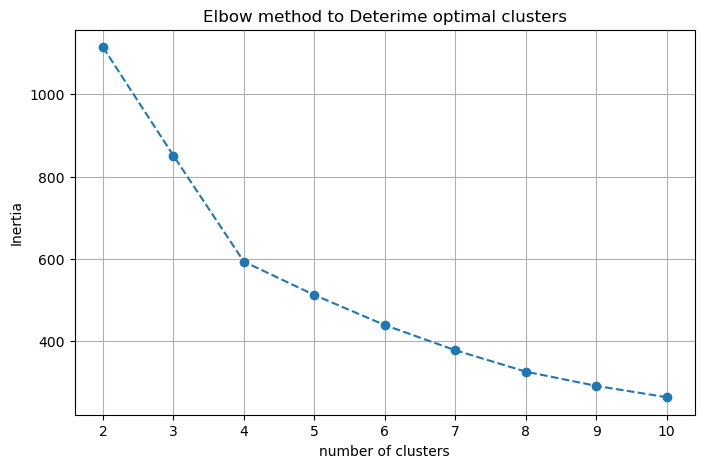

In [115]:
inert=[]
k_values=range(2,11)
for k in k_values:
    kmeans=KMeans(n_clusters=k,random_state=45,n_init=10)
    kmeans.fit(scl_features)
    inert.append(kmeans.inertia_)
plt.figure(figsize=(8,5))
plt.plot(k_values,inert,marker='o',linestyle='--')
plt.title('Elbow method to Deterime optimal clusters')
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [117]:
#apply kmeans clustring

op=4
kmeans=KMeans(n_clusters=op,random_state=42)
clu=kmeans.fit_predict(scl_features)


In [119]:
#add cluster labels
cus_features['cluster']=clu

In [121]:
#evaluate clustring using Davdavies_bouldin_score and silhouette score

db_index=davies_bouldin_score(scl_features,clu)
sil_score=silhouette_score(scl_features,clu)

In [123]:
db_index

0.9319194864587907

In [125]:
sil_score

0.46339635926529227

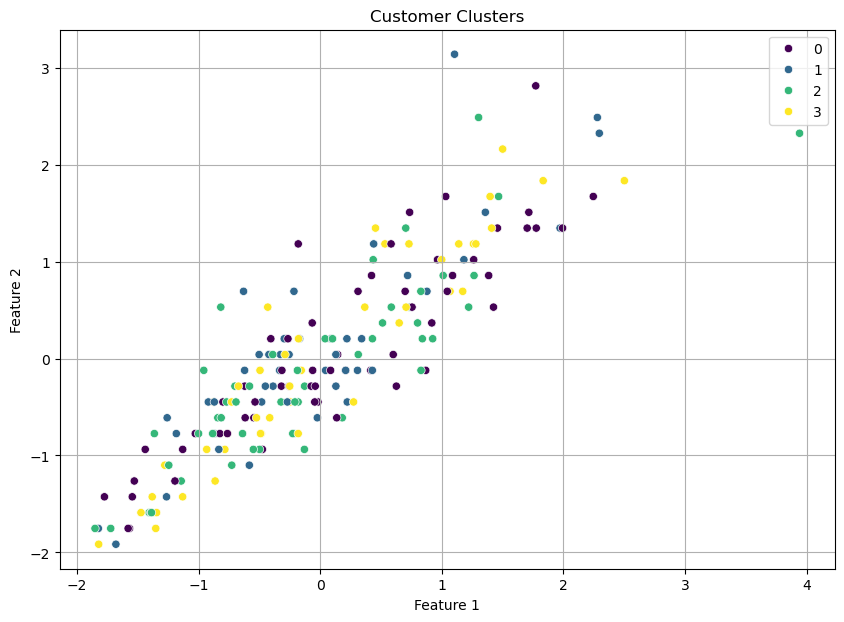

In [127]:
#visualize clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=scl_features[:,0],
    y=scl_features[:,1],
    hue=clu,
    palette="viridis",
    legend='full')
plt.title('Customer Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.show()

In [129]:
cus_features.to_csv('kalyani_botla_clustring.csv',index=False)

In [152]:
print(f"Optimal number of clusters: {op}")

Optimal number of clusters: 4
